In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

C:\Users\foura\anaconda3\envs\tensorflow-gpu310\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_hub")


In [4]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" ,input_shape=IMAGE_SHAPE+(3,))
])  

### Classifier is a pretrained model that we imported from tensorflow hub

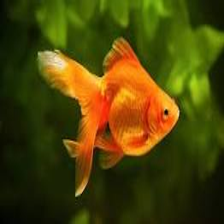

In [5]:
Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

In [6]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

In [7]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [8]:
gold_fish[np.newaxis,...].shape

(1, 224, 224, 3)

In [9]:
result = classifier.predict(gold_fish[np.newaxis,...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

In [10]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [11]:
image_labels = []
with open("ImageNetLabels.txt" , "r") as f :
    image_labels = f.read().splitlines()
image_labels[:5]    

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
image_labels[predicted_label_index]

'goldfish'

### Load flowers dataset

In [13]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [14]:
data_dir

'.\\datasets\\flower_photos'

In [15]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [16]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [17]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [18]:
str(roses[0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

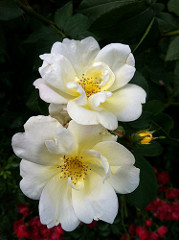

In [19]:
Image.open(str(roses[0]))

<h3 style="color :Blue;">Read flowers images from disk into numpy array using opencv</h3>

In [20]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [21]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [22]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 179, 3)

In [23]:
img = cv2.imread(str(flowers_images_dict['roses'][1]))
img.shape

(240, 320, 3)

In [24]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [25]:
X = np.array(X)
y = np.array(y)

<h3 style="color:Blue;">Train Test Split</h3>

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train = X_train / 255
X_test = X_test / 255

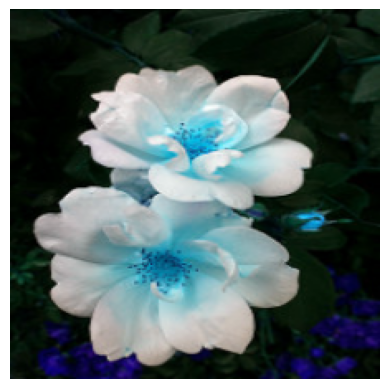

In [28]:
plt.axis('off')
plt.imshow(X[0])

In [29]:
predicted = classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted,axis=1)
predicted

1/1 [==============================] - 1s 807ms/step


array([795, 880, 795], dtype=int64)

### Now take pre-trained model and retrain it using flowers images


<h3 style="         
    line-height: 1.8;  
    margin-bottom: 15px;  
    font-family: Arial, sans-serif;
">
Now we will take the classifier model but we will extract from it the last layer.  
This is why 
<a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" target="_blank">classification/4</a> 
will be replaced with 
<a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" target="_blank">feature_vector/4</a>.
</h3>


In [30]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [31]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
BATCH_SIZE = 8

with tf.device('/CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = (
        train_ds
        .shuffle(1000)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [33]:
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

print(X_train.shape, X_train.dtype)

(2752, 224, 224, 3) float32


In [34]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
344/344 [==============================] - 84s 223ms/step - loss: 0.6146 - acc: 0.7736 - val_loss: 0.4779 - val_acc: 0.8290
Epoch 2/5
344/344 [==============================] - 79s 231ms/step - loss: 0.3143 - acc: 0.8917 - val_loss: 0.3904 - val_acc: 0.8519
Epoch 3/5
344/344 [==============================] - 180s 524ms/step - loss: 0.2321 - acc: 0.9270 - val_loss: 0.3908 - val_acc: 0.8573
Epoch 4/5
344/344 [==============================] - 176s 513ms/step - loss: 0.1837 - acc: 0.9466 - val_loss: 0.3986 - val_acc: 0.8529
Epoch 5/5
344/344 [==============================] - 172s 501ms/step - loss: 0.1529 - acc: 0.9549 - val_loss: 0.3855 - val_acc: 0.8736


In [36]:
model.evaluate(X_test,y_test)

29/29 [==============================] - 24s 668ms/step - loss: 0.3855 - acc: 0.8736


[0.3855029344558716, 0.8736383318901062]